# Reconstrucci√≥n de im√°genes y eliminaci√≥n de ruido usando Autoencoders

### Objetivo:  Comparar el desempe√±o de ambos modelos y analizar visualmente los resultados obtenidos.

### **Introducci√≥n a los Autoencoders**

#### ¬øQu√© es un Autoencoder? üß†

Un autoencoder es un tipo de red neuronal artificial que se utiliza para aprender representaciones eficientes de datos de una manera no supervisada. Su objetivo principal es aprender una representaci√≥n (codificaci√≥n) para un conjunto de datos, t√≠picamente para la **reducci√≥n de dimensionalidad** o la **extracci√≥n de caracter√≠sticas**.

La arquitectura de un autoencoder se compone de tres partes principales:

1.  **Codificador (Encoder):** Es la primera mitad de la red. Su funci√≥n es tomar los datos de entrada y comprimirlos en una representaci√≥n de menor dimensi√≥n, conocida como el **espacio latente** o *bottleneck* (cuello de botella). Esta representaci√≥n latente captura las caracter√≠sticas m√°s importantes de los datos.
2.  **Espacio Latente (Latent Space):** Es la capa central y m√°s peque√±a de la red, que contiene la representaci√≥n comprimida de los datos de entrada. La dimensionalidad de este espacio es un hiperpar√°metro clave que define cu√°nta compresi√≥n se realiza.
3.  **Decodificador (Decoder):** Es la segunda mitad de la red. Su objetivo es tomar la representaci√≥n comprimida del espacio latente y reconstruir los datos de entrada originales con la menor p√©rdida de informaci√≥n posible.

En este ejercicio, implementaremos dos variantes:

  * Parte A: Un **Autoencoder B√°sico** para comprimir y reconstruir im√°genes.
  * Parte B: Un **Autoencoder de Eliminaci√≥n de Ruido (Denoising)**, que aprende a crear im√°genes limpias a partir de versiones ruidosas.


### **1. Importaci√≥n de Librer√≠as y Carga de Datos**

In [14]:
# Importar TensorFlow y Keras para la construcci√≥n de la red neuronal.
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Importar NumPy para operaciones num√©ricas, especialmente para a√±adir ruido.
import numpy as np

# Importar Matplotlib para la visualizaci√≥n de las im√°genes.
import matplotlib.pyplot as plt

# --- Carga del Dataset MNIST ---
# MNIST es un dataset cl√°sico de d√≠gitos escritos a mano (0-9).
# No necesitamos las etiquetas (y_train, y_test), por lo que las descartamos con '_'.
(x_train, _), (x_test, _) = mnist.load_data()


### **2. Preprocesamiento de los Datos: Normalizaci√≥n y Aplanamiento**

Antes de entrenar nuestra red, es fundamental preparar los datos. Realizaremos dos pasos clave:

1.  **Normalizaci√≥n:** Las im√°genes del dataset MNIST tienen valores de p√≠xeles que van de 0 (negro) a 255 (blanco). Para que el entrenamiento de la red neuronal sea m√°s estable y eficiente, escalaremos estos valores a un rango entre 0 y 1. Esto se logra simplemente dividiendo todos los valores de los p√≠xeles por 255.

2.  **Aplanamiento (Flattening):** Las capas que usaremos (`Dense`) esperan recibir los datos como un vector unidimensional. Por lo tanto, debemos transformar cada imagen, que es una matriz de 28x28 p√≠xeles, en un vector plano de 784 elementos (28 \* 28 = 784).

Estos pasos aseguran que los datos est√©n en el formato y rango adecuados para ser procesados por la red.

In [15]:
# --- Normalizaci√≥n ---
# Convertimos el tipo de dato a 'float32' para permitir la divisi√≥n con decimales.
# Dividimos cada valor de p√≠xel por 255 para escalar los datos al rango [0, 1].
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# --- Aplanamiento ---
# Cambiamos la forma de cada imagen de una matriz 2D (28, 28) a un vector 1D de 784 elementos.
# `np.prod(x_train.shape[1:])` calcula autom√°ticamente el producto de las dimensiones (28*28).
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Imprimimos las formas resultantes para verificar que el preprocesamiento fue correcto.
print("Forma del set de entrenamiento:", x_train.shape)
print("Forma del set de prueba:", x_test.shape)

Forma del set de entrenamiento: (60000, 784)
Forma del set de prueba: (10000, 784)


### **Parte A - Construcci√≥n del Autoencoder B√°sico**

Ahora construiremos el primer modelo. Utilizaremos la API Funcional de Keras, que ofrece gran flexibilidad para definir arquitecturas complejas.

La arquitectura ser√° sim√©trica:

  * **Capa de Entrada:** Recibir√° nuestros vectores aplanados de 784 dimensiones.
  * **Codificador:**
    1.  Una capa `Dense` con 128 neuronas y activaci√≥n `ReLU` que reduce la dimensionalidad.
    2.  Una segunda capa `Dense` con 64 neuronas y activaci√≥n `ReLU` que define nuestro **espacio latente**.
  * **Decodificador:**
    1.  Una capa `Dense` con 128 neuronas y activaci√≥n `ReLU` que comienza a expandir la representaci√≥n.
    2.  Una capa `Dense` de salida con 784 neuronas y activaci√≥n `Sigmoid`.

**Elecci√≥n de Funciones de Activaci√≥n:**

  - **`ReLU` (Rectified Linear Unit):** Es una excelente opci√≥n para las capas ocultas, ya que es computacionalmente eficiente y ayuda a mitigar el problema del desvanecimiento del gradiente.
  - **`Sigmoid`:** Es ideal para la capa de salida porque produce valores en el rango (0, 1), que coincide perfectamente con el rango de nuestros datos de p√≠xeles normalizados.


In [16]:
# Dimensi√≥n del espacio latente (nuestra representaci√≥n comprimida).
encoding_dim = 64
# Dimensi√≥n de la entrada (28*28 = 784 p√≠xeles).
input_dim = 784

# --- Definici√≥n de la arquitectura ---

# 1. Capa de entrada: Define la forma de los datos que recibir√° el modelo.
input_img = Input(shape=(input_dim,))

# 2. Codificador: Mapea la entrada a la representaci√≥n latente.
# Primera capa densa del codificador.
encoded = Dense(128, activation='relu')(input_img)
# Segunda capa densa que produce la codificaci√≥n final de 64 dimensiones.
encoded = Dense(encoding_dim, activation='relu')(encoded)

# 3. Decodificador: Reconstruye la entrada a partir de la representaci√≥n latente.
# Primera capa densa del decodificador.
decoded = Dense(128, activation='relu')(encoded)
# Capa de salida que reconstruye la imagen original de 784 p√≠xeles.
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 4. Modelo completo: Se instancia el modelo especificando las capas de entrada y salida.
autoencoder = Model(input_img, decoded)

# Imprime un resumen de la arquitectura del modelo, mostrando las capas y el n√∫mero de par√°metros.
autoencoder.summary()

Model: "functional_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_2 (InputLayer)      ‚îÇ (None, 784)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 128)            ‚îÇ       100,480 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ (None, 128)            ‚îÇ         8,320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ (None, 784)            ‚îÇ       101,136 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)


### **Compilaci√≥n, M√©trica de P√©rdida y Entrenamiento**

Antes de entrenar, debemos "compilar" el modelo. Este paso configura el proceso de aprendizaje y requiere tres componentes clave:

1.  **Optimizador (`optimizer`):** Es el algoritmo que ajusta los pesos de la red para minimizar la funci√≥n de p√©rdida. Usaremos **`adam`**, un optimizador muy popular y efectivo que adapta la tasa de aprendizaje durante el entrenamiento, lo que generalmente conduce a una convergencia m√°s r√°pida y robusta.

2.  **Funci√≥n de P√©rdida (`loss`):** Mide qu√© tan bien est√° funcionando el modelo. La meta del entrenamiento es minimizar este valor. Usaremos **`binary_crossentropy`**. Aunque su nombre sugiere que es para clasificaci√≥n binaria, es una excelente opci√≥n para la reconstrucci√≥n de im√°genes con p√≠xeles normalizados entre 0 y 1. Trata a cada p√≠xel de la imagen reconstruida como una predicci√≥n de probabilidad (la probabilidad de que ese p√≠xel sea "blanco") y la compara con el valor real del p√≠xel en la imagen original. Mide la distancia entre estas dos distribuciones de probabilidad, p√≠xel por p√≠xel, y las suma. Un valor de p√©rdida bajo indica que la reconstrucci√≥n es muy similar al original.


In [17]:
# --- Compilaci√≥n del Modelo ---
# Se configura el optimizador 'adam' y la funci√≥n de p√©rdida 'binary_crossentropy'.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# --- Entrenamiento del Modelo ---
# El m√©todo `fit` inicia el proceso de entrenamiento.
autoencoder.fit(
    x_train,          # Datos de entrada para el entrenamiento.
    x_train,          # Datos objetivo (en un autoencoder b√°sico, la salida es igual a la entrada).
    epochs=50,        # N√∫mero de veces que el modelo ver√° el dataset completo.
    batch_size=256,   # N√∫mero de muestras por actualizaci√≥n de gradiente.
    shuffle=True,     # Mezcla los datos de entrenamiento antes de cada epoch para evitar sesgos.
    validation_data=(x_test, x_test) # Datos para evaluar el rendimiento del modelo despu√©s de cada epoch.
)

Epoch 1/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - loss: 0.3210 - val_loss: 0.1395
Epoch 2/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 15ms/step - loss: 0.1314 - val_loss: 0.1105
Epoch 3/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 14ms/step - loss: 0.1090 - val_loss: 0.1002
Epoch 4/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 14ms/step - loss: 0.1004 - val_loss: 0.0951
Epoch 5/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 18ms/step - loss: 0.0955 - val_loss: 0.0917
Epoch 6/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 19ms/step - loss: 0.0925 - val_loss: 0.0893
Epoch 7/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 13ms/step - loss: 0.0896 - val_loss: 0.0869
Epoch 8/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - loss: 0.0875 - v

A continuacion se implementa la **reconstrucci√≥n de im√°genes** usando un **autoencoder** ya entrenado. El prop√≥sito es demostrar visualmente c√≥mo el modelo, despu√©s de aprender una representaci√≥n comprimida, puede regenerar una imagen a partir de ella.

El proceso tiene dos pasos:

### **1. Predicci√≥n (Reconstrucci√≥n)**

Primero, el c√≥digo utiliza el m√©todo `autoencoder.predict(x_test)`. Este comando toma cada imagen del conjunto de prueba (`x_test`) y la pasa a trav√©s de la arquitectura completa del autoencoder. El modelo primero **codifica** la imagen en un **espacio latente** o **cuello de botella** de menor dimensi√≥n, capturando sus caracter√≠sticas esenciales. Luego, el decodificador usa esta representaci√≥n comprimida para **reconstruir** la imagen. El resultado, `reconstructed_imgs`, es una matriz con las versiones reconstruidas de las im√°genes originales.


### **2. Visualizaci√≥n**

La segunda parte se encarga de mostrar los resultados para una **comparaci√≥n visual directa**. Se crea un gr√°fico con `matplotlib` para visualizar 10 im√°genes. La **fila superior** muestra las im√°genes originales del conjunto de prueba (`x_test`). La **fila inferior** presenta las im√°genes reconstruidas por el autoencoder (`reconstructed_imgs`). Ambas filas de im√°genes se muestran en escala de grises. Este despliegue permite evaluar visualmente la **calidad de la reconstrucci√≥n**, midiendo qu√© tan bien el autoencoder ha aprendido a retener la informaci√≥n clave de las im√°genes para recrearlas.

313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step


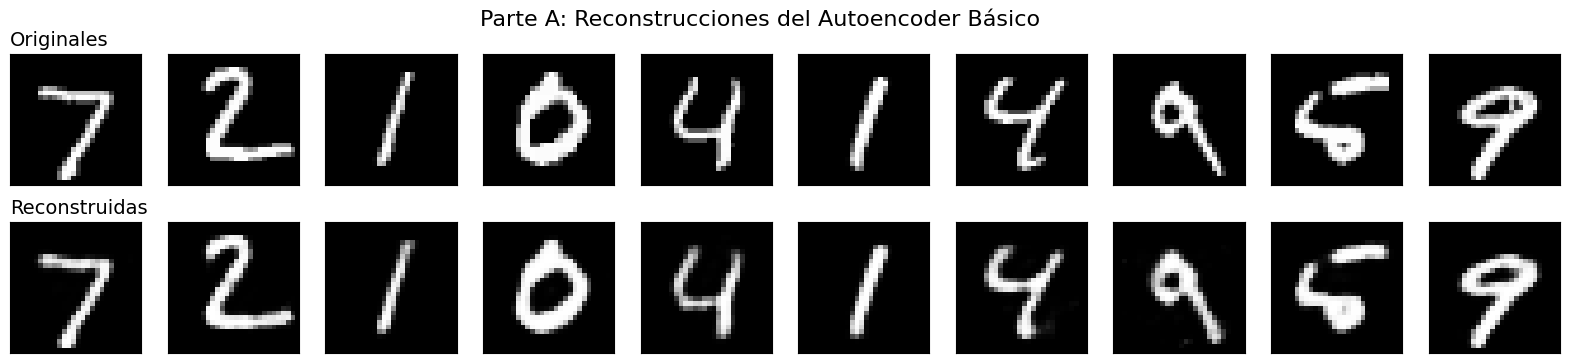

In [18]:
# Usamos el modelo entrenado para predecir (reconstruir) las im√°genes del conjunto de prueba.
reconstructed_imgs = autoencoder.predict(x_test)

# --- Visualizaci√≥n de Resultados ---
n = 10  # N√∫mero de d√≠gitos a mostrar.
plt.figure(figsize=(20, 4)) # Define el tama√±o de la figura que contendr√° las im√°genes.
plt.suptitle("Parte A: Reconstrucciones del Autoencoder B√°sico", fontsize=16)

for i in range(n):
    # Mostrar imagen original.
    # Se crea un subplot en la primera fila.
    ax = plt.subplot(2, n, i + 1)
    # Se muestra la i-√©sima imagen de prueba, remodelada a 28x28.
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    # Se ocultan los ejes X e Y para una visualizaci√≥n m√°s limpia.
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Se a√±ade un t√≠tulo a la primera imagen de la fila.
    if i == 0: ax.set_title("Originales", loc='left', fontdict={'fontsize': 14})


    # Mostrar imagen reconstruida.
    # Se crea un subplot en la segunda fila.
    ax = plt.subplot(2, n, i + 1 + n)
    # Se muestra la i-√©sima imagen reconstruida, remodelada a 28x28.
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    # Se ocultan los ejes.
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Se a√±ade un t√≠tulo a la primera imagen de la fila.
    if i == 0: ax.set_title("Reconstruidas", loc='left', fontdict={'fontsize': 14})

# Muestra la figura con todas las im√°genes.
plt.show()

--------

### **Parte B - Autoencoder Denoising**

La segunda parte de la actividad se enfoca en una tarea m√°s avanzada y √∫til: la **eliminaci√≥n de ruido**. Un autoencoder *denoising* se entrena para reconstruir una imagen limpia a partir de una entrada corrupta con ruido.

El proceso es el siguiente:

1.  **Generaci√≥n de Ruido:** Tomaremos las im√°genes originales del dataset MNIST y les a√±adiremos ruido gaussiano. Este ruido simula las imperfecciones que pueden ocurrir en datos del mundo real.
2.  **Entrenamiento Modificado:** La arquitectura del modelo puede ser la misma, pero la clave est√° en el entrenamiento. Alimentaremos la red con las **im√°genes ruidosas** como entrada (`x_train_noisy`) y le pediremos que produzca las **im√°genes limpias originales** como salida (`x_train`).

De esta forma, el modelo no puede simplemente aprender a copiar la entrada; se ve forzado a aprender las caracter√≠sticas estructurales de los d√≠gitos para poder distinguir la "se√±al" (el d√≠gito) del "ruido" y eliminar este √∫ltimo.

### **Generaci√≥n de Datos Ruidosos y Entrenamiento**

In [19]:
# --- 1. Generar im√°genes ruidosas ---
# Define la intensidad del ruido. Un valor m√°s alto significa m√°s ruido.
noise_factor = 0.5
# Se genera ruido gaussiano con media 0 y desviaci√≥n est√°ndar 1, con la misma forma que nuestros datos.
# Este ruido se multiplica por el `noise_factor` y se suma a las im√°genes originales.
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# --- Recortar (Clip) los valores ---
# Al sumar el ruido, algunos valores de p√≠xeles pueden salirse del rango [0, 1].
# `np.clip` asegura que todos los valores se mantengan dentro de este rango v√°lido.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# --- 2. Construir y entrenar el modelo de Denoising ---
# Podemos usar la misma arquitectura del autoencoder b√°sico.
denoising_autoencoder = autoencoder
# Se compila nuevamente para reiniciar el estado del optimizador.
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# La diferencia clave est√° aqu√≠:
# La entrada son las im√°genes ruidosas (x_train_noisy).
# El objetivo son las im√°genes limpias (x_train).
denoising_autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=100, # Denoising es una tarea m√°s dif√≠cil, por lo que se usan m√°s epochs.
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - loss: 0.1969 - val_loss: 0.1372
Epoch 2/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 14ms/step - loss: 0.1336 - val_loss: 0.1241
Epoch 3/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 15ms/step - loss: 0.1230 - val_loss: 0.1189
Epoch 4/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 13ms/step - loss: 0.1183 - val_loss: 0.1164
Epoch 5/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 13ms/step - loss: 0.1159 - val_loss: 0.1148
Epoch 6/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 15ms/step - loss: 0.1143 - val_loss: 0.1140
Epoch 7/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 13ms/step - loss: 0.1132 - val_loss: 0.1131
Epoch 8/100
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 17ms/step - loss: 0.

Como comentamos, el siguiente c√≥digo se enfoca en el uso de un **autoencoder de eliminaci√≥n de ruido** (*denoising autoencoder*) para limpiar im√°genes corrompidas. El objetivo es visualizar y comparar la capacidad del modelo para reconstruir versiones claras de im√°genes que han sido intencionalmente alteradas con ruido.

### **Proceso y Visualizaci√≥n**

El proceso comienza con la predicci√≥n, donde el modelo `denoising_autoencoder.predict(x_test_noisy)` toma un conjunto de im√°genes ruidosas (`x_test_noisy`) como entrada. La red neuronal ha sido entrenada para reconocer y eliminar el ruido, generando como resultado im√°genes `denoised_imgs` que se asemejan a sus contrapartes originales y limpias.

---

La visualizaci√≥n es crucial para evaluar la efectividad del modelo. Se crea un gr√°fico con `matplotlib` que organiza las im√°genes en tres filas para una comparaci√≥n directa y clara:

* **Fila superior:** Muestra las **im√°genes ruidosas** que se le dieron como entrada al modelo.
* **Fila intermedia:** Exhibe las **im√°genes limpiadas** o reconstruidas por el autoencoder.
* **Fila inferior:** Presenta las **im√°genes originales** (sin ruido) como la verdad fundamental (*ground truth*).

Esta disposici√≥n permite al usuario comparar c√≥mo el modelo transform√≥ las im√°genes ruidosas y qu√© tan cerca quedaron de las originales, demostrando su eficacia en la tarea de denoising.

313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step


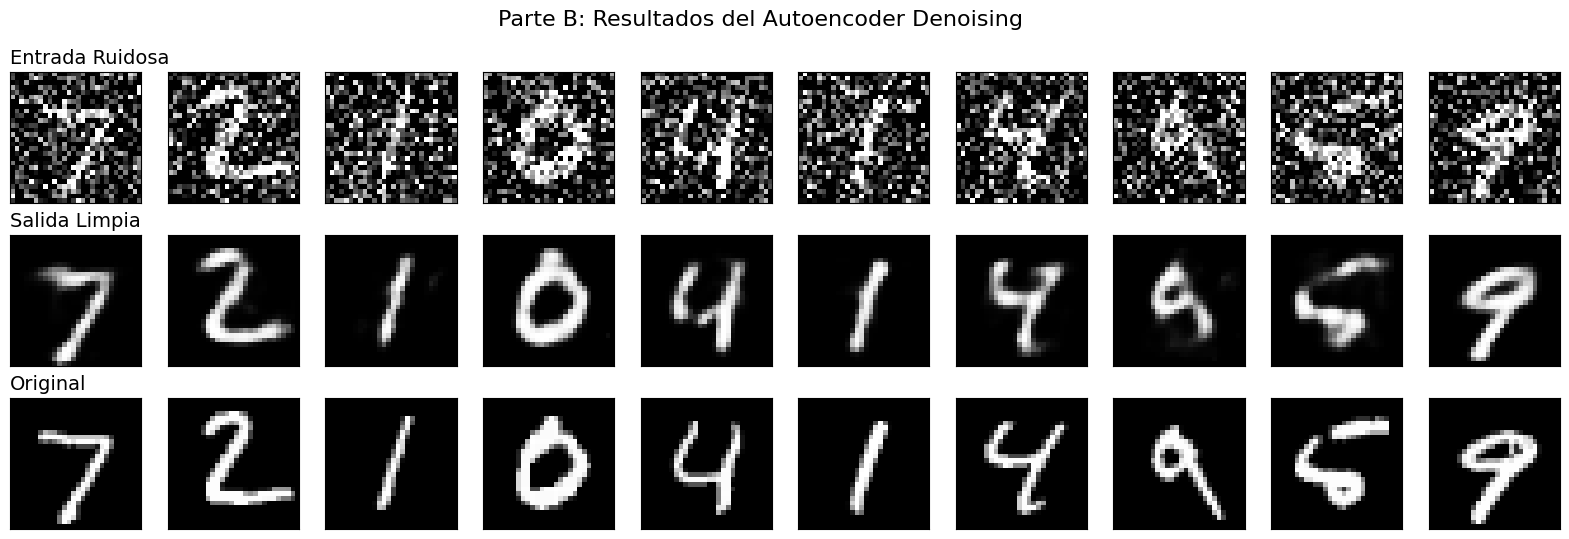

In [20]:
# Usamos el modelo denoising para predecir im√°genes limpias a partir de las de prueba ruidosas.
denoised_imgs = denoising_autoencoder.predict(x_test_noisy)

# --- Visualizaci√≥n Comparativa ---
n = 10
plt.figure(figsize=(20, 6))
plt.suptitle("Parte B: Resultados del Autoencoder Denoising", fontsize=16)

for i in range(n):
    # Mostrar entrada ruidosa.
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Entrada Ruidosa", loc='left', fontdict={'fontsize': 14})


    # Mostrar salida limpia (reconstrucci√≥n).
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Salida Limpia", loc='left', fontdict={'fontsize': 14})


    # Mostrar imagen original (Ground Truth).
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Original", loc='left', fontdict={'fontsize': 14})

plt.show()


### **An√°lisis Comparativo Profesional**

#### Evaluaci√≥n Cuantitativa (M√©tricas) üìä

Al final del entrenamiento, cada modelo reporta un valor de `val_loss` (p√©rdida en el conjunto de validaci√≥n).

  * **Autoencoder B√°sico:** T√≠picamente, alcanza un `val_loss` final **m√°s bajo**. En este caso ronda \~0.075. Esto es esperable, ya que su tarea es una reconstrucci√≥n directa. La p√©rdida mide √∫nicamente el error introducido por el ciclo de compresi√≥n-descompresi√≥n.
  * **Autoencoder Denoising:** Su `val_loss` final ser√° **m√°s alto**, en estew caso, \~0.10. Esto **no significa que sea un peor modelo**. Al contrario, est√° resolviendo un problema mucho m√°s dif√≠cil: la p√©rdida no solo mide el error de reconstrucci√≥n, sino tambi√©n el error residual tras eliminar una cantidad significativa de ruido. El valor absoluto de la p√©rdida es mayor porque la distancia entre la entrada (ruidosa) y la salida (limpia) es intr√≠nsecamente grande. Lo importante es que el modelo logra minimizar esta p√©rdida, demostrando su capacidad de transformaci√≥n.

#### Evaluaci√≥n Cualitativa (Visual) üëÅÔ∏è

  * **Autoencoder B√°sico:** Las im√°genes reconstruidas son muy claras pero a menudo **ligeramente borrosas** en comparaci√≥n con las originales. Se puede notar una p√©rdida de detalles finos y bordes menos n√≠tidos. Esto es una consecuencia directa de la compresi√≥n con p√©rdida: el modelo aprendi√≥ las caracter√≠sticas m√°s importantes pero descart√≥ informaci√≥n de alta frecuencia (detalles sutiles).
  * **Autoencoder Denoising:** Los resultados visuales son la evidencia m√°s contundente de su poder. A pesar de recibir entradas muy degradadas, las salidas son **notablemente limpias y legibles**. El modelo no solo reconstruye el d√≠gito, sino que lo "restaura", eliminando el ruido gaussiano de manera efectiva. Aunque la salida puede no ser tan n√≠tida como la del autoencoder b√°sico (ya que parte de la informaci√≥n se pierde irreversiblemente por el ruido), su capacidad para separar la se√±al del ruido es impresionante.

#### Conclusi√≥n Profesional

Ambos modelos son exitosos en sus respectivas tareas. Sin embargo, el **autoencoder de eliminaci√≥n de ruido demuestra una capacidad de aprendizaje superior y m√°s robusta**. No se limita a aprender una compresi√≥n, sino que aprende la **estructura subyacente** o el *manifold* de los datos de los d√≠gitos. Este conocimiento profundo le permite generalizar y reconstruir la esencia de un d√≠gito incluso desde una versi√≥n corrupta, una habilidad crucial para aplicaciones en el mundo real donde los datos rara vez son perfectos.

-----

### **Reflexi√≥n sobre Aplicaciones Potenciales**

La t√©cnica de autoencoders, especialmente la de eliminaci√≥n de ruido, tiene un potencial inmenso en m√∫ltiples dominios profesionales, donde la integridad y calidad de los datos son primordiales.

#### Medicina ü©∫

En el campo de la imagenolog√≠a m√©dica (MRI, CT, Rayos X), las im√°genes a menudo contienen ruido y artefactos que pueden ocultar detalles patol√≥gicos cruciales. Un autoencoder *denoising* puede ser entrenado en grandes datasets de im√°genes m√©dicas para **limpiar y mejorar la calidad de las exploraciones**. Esto podr√≠a permitir a los m√©dicos detectar tumores en etapas m√°s tempranas, identificar fracturas sutiles o mejorar la segmentaci√≥n de √≥rganos, llevando a diagn√≥sticos m√°s precisos y tratamientos m√°s efectivos.

#### Seguridad üõ°Ô∏è

En seguridad y vigilancia, las grabaciones de video suelen ser de baja resoluci√≥n o estar afectadas por malas condiciones de iluminaci√≥n o ruido de compresi√≥n. Los autoencoders pueden **mejorar la calidad de estas im√°genes**, facilitando la identificaci√≥n de rostros o matr√≠culas en investigaciones forenses. Adem√°s, en ciberseguridad, los autoencoders son excelentes para la **detecci√≥n de anomal√≠as**. Entrenados con datos de tr√°fico de red "normal", pueden identificar patrones an√≥malos (con un alto error de reconstrucci√≥n) que podr√≠an indicar un ciberataque o una intrusi√≥n en el sistema.

#### Industria y Manufactura üè≠

En las l√≠neas de producci√≥n, el control de calidad visual es fundamental. Se puede entrenar un autoencoder con miles de im√°genes de productos sin defectos. Durante la producci√≥n, el sistema puede analizar im√°genes de nuevos productos. Si un producto tiene un defecto (una grieta, una mancha, una deformidad), el modelo no podr√° reconstruirlo con un error bajo. Este **alto error de reconstrucci√≥n** servir√≠a como una se√±al para rechazar autom√°ticamente el producto defectuoso, automatizando y mejorando la precisi√≥n del control de calidad 24/7.